In [10]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import baestorm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyswmm_lite import environment
from GPyOpt.methods import BayesianOptimization
import copy
import GPyOpt
import sklearn.preprocessing

In [11]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y
gaussian_flows = np.vectorize(gaussian_flows)

In [12]:
means = [0.0]#, -0.1, -0.2, 0.1, 0.2]
sigma = [1.0, 2.0, 0.5, 0.3]

inflows = {}
count = 0
for mu in means:
    for sig in sigma:
        inflows[str(count)] = gaussian_flows(np.linspace(-5.0, 5.0, 1000), mu, sig)
        count += 1
inflows = pd.DataFrame.from_dict(inflows)

In [13]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(500))
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)

        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))

        # step through simulation
        _ = env.step()

    return data["outflow"], sum(data["overflow"])

In [23]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, inflows.shape[1]-1, inflows.shape[1], dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows = single_basin(valves, inflows[str(temp_1)].values)
    # Convert to pandas series for ease of ops
    flows = pd.Series(flows)
    overflows = pd.Series(overflows)
    # Compute performance
    reward = 0.0
    overflows = overflows.gt(0.0).any()
    if overflows:
        reward += 10**3
    flows = flows.sub(1.5)
    flows[flows < 0.0] = 0.0
    reward += flows.sum()
    return reward

# Set the random seed
np.random.seed(42)

# Create an objective function
class Objective:
    def f(self, x):
        return objective_function(x)

# Initalize the objective
Obj_temp = Objective()
Obj_temp = GPyOpt.core.task.SingleObjective(Obj_temp.f)

# Create Search Space
Search_Space = GPyOpt.Design_space(space=[{"name": "var_1", "type": "continuous", "domain": (0.0, 1.0)}])
# Pick a kernel
kernel = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
# Set up the model
model = GPyOpt.models.GPModel(kernel=kernel,
                              noise_var=0.0,
                              optimize_restarts=5,
                              verbose=False)

# How do you sample the region
initial_design = GPyOpt.experiment_design.initial_design("random",
                                                         Search_Space,
                                                         5)

# Choose the acquision function
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(Search_Space)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model,
                                                Search_Space,
                                                acq_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(model,
                                                Search_Space,
                                                Obj_temp,
                                                acquisition,
                                                evaluator,
                                                initial_design)

log = bo.run_optimization(
    "./ckpts-uncertain_inital_test/",
    max_iter=50,
    save_inter_models=False,
    intervals=100)

In [7]:
bo.model.model.kern.rbf

rbf.,value,constraints,priors
variance,1856.5015245688899,+ve,
lengthscale,0.07386583340589097,+ve,


In [8]:
def plot_acquisition(axis, model):
    bounds = model.acquisition.space.get_bounds()

    x_grid = np.arange(bounds[0][0], bounds[0][1], 0.001)
    x_grid = x_grid.reshape(len(x_grid), 1)
    # acqu = model.acquisition.acquisition_function(x_grid)
    # acqu_normalized = (-acqu - min(-acqu)) / (max(-acqu - min(-acqu)))
    m, v = model.model.predict(x_grid)
    factor = max(m + 1.96 * np.sqrt(v)) - min(m - 1.96 * np.sqrt(v))
    axis.plot(x_grid, m, color="#D5313E", lw=2.0)
    axis.plot(x_grid, m - 1.96 * np.sqrt(v), color="#445792")
    axis.plot(x_grid, m + 1.96 * np.sqrt(v), color="#445792")
    axis.fill_between(
        np.ravel(x_grid),
        np.ravel(m - 1.96 * np.sqrt(v)),
        np.ravel(m + 1.96 * np.sqrt(v)),
        color="#445792",
        alpha=0.5,
    )
    y = model.Y - model.Y.mean()
    y = y / model.Y.std()
    axis.scatter(model.X[:-1], y[:-1], color="#9F383E", marker="o")

    axis.set_xlabel("Valve Setting")
    axis.set_ylabel("Objective")
    axis.set_ylim(
        min(m - 1.96 * np.sqrt(v)) - 0.25 * factor,
        max(m + 1.96 * np.sqrt(v)) + 0.05 * factor,
    )

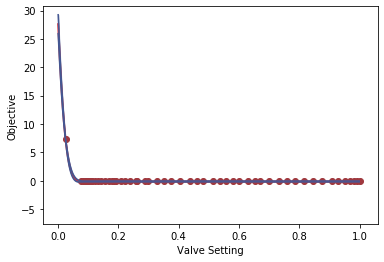

In [9]:
ax = plt.subplot(1,1,1)
plot_acquisition(ax, bo)

In [13]:
x = bo.X
y = bo.Y
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x,y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 10)
var_pref = np.zeros((x.shape[0],1))

Optimization restart 1/10, f = 347.76650665746405
Optimization restart 2/10, f = 347.76651911566944
Optimization restart 3/10, f = 347.766883860924
Optimization restart 4/10, f = 347.7665026450487
Optimization restart 5/10, f = 347.7665162586835
Optimization restart 6/10, f = 347.76654794429464
Optimization restart 7/10, f = 347.7666010054268
Optimization restart 8/10, f = 347.7665657829417
Optimization restart 9/10, f = 347.7671051542999
Optimization restart 10/10, f = 347.76651808402517


In [14]:
eps = np.inf
iterations = 0

m, v = gp1.predict(x)
s = 10
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

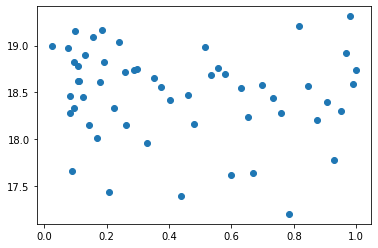

In [15]:
plt.plot(x, z,'o')

In [16]:
kernel2 = GPy.kern.RBF(input_dim=1) #+ GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x,z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 10)
m_n, v_n = gp2.predict(x)

Optimization restart 1/10, f = 43.277438014864686
Optimization restart 2/10, f = 43.27744105548901
Optimization restart 3/10, f = 43.27749407114582
Optimization restart 4/10, f = 43.27747283234583
Optimization restart 5/10, f = 43.277433937579964
Optimization restart 6/10, f = 43.27866122069321
Optimization restart 7/10, f = 43.27752543497388
Optimization restart 8/10, f = 43.28015278924674
Optimization restart 9/10, f = 43.277433843568595
Optimization restart 10/10, f = 43.27746455457447


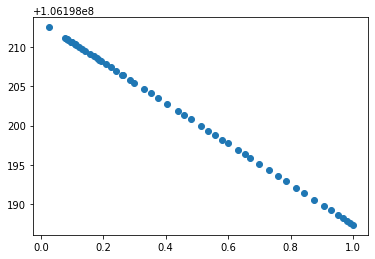

In [17]:
plt.plot(x, np.exp(m_n), 'o')

In [18]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x,y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 10)
kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

Optimization restart 1/10, f = -438.38495078779533
Optimization restart 2/10, f = -438.51686665478866
Optimization restart 3/10, f = -438.5285940059793
Optimization restart 4/10, f = -438.46199005530116
Optimization restart 5/10, f = -438.2976715976403
Optimization restart 6/10, f = -438.3433652587543
Optimization restart 7/10, f = -438.6755599740691
Optimization restart 8/10, f = -438.4121263194979
Optimization restart 9/10, f = -438.43494730611474
Optimization restart 10/10, f = -438.36623224684183


In [19]:
m, v = gp3.predict(x)
    
diff = var_pref - v
eps = np.dot(diff.T, diff)[0][0]
gp1 = copy.deepcopy(gp3)
var_pref = copy.deepcopy(v)
print(eps)

6.202931957795446e+17


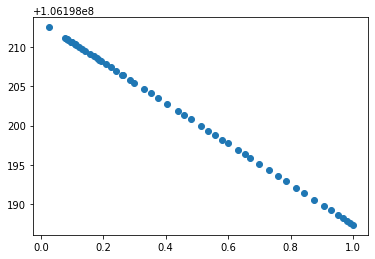

In [20]:
plt.plot(x,np.exp(m_n),'o')

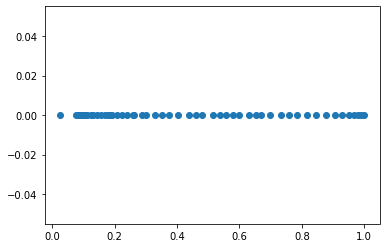

In [21]:
plt.plot(x, m, 'o')